In [1]:
# Cell 1: Load and convert Fashion MNIST dataset to a DataFrame
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
import torch.nn.functional as F
import time


### Pretend we are NOT doing this - imagine it being you donwloading data from the internet

In [2]:
# ✅ Define Transformations
transform = transforms.ToTensor()

# ✅ Load CIFAR-10 Train & Test Datasets
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# ✅ Merge Train & Test into Full Dataset
full_dataset = train_dataset + test_dataset  # Creates a ConcatDataset

# ✅ Manually Define CIFAR-10 Class Names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]


Files already downloaded and verified
Files already downloaded and verified


In [3]:
# # ✅ Convert Images to NumPy Arrays
# data = []
# labels = []
# for img, label in full_dataset:
#     img_array = img.numpy().flatten()  # Flatten image into 1D array
#     data.append(img_array)
#     labels.append(label)

# # ✅ Create DataFrame
# columns = [f"pixel_{i}" for i in range(32 * 32 * 3)]  # 32x32 RGB Image
# df = pd.DataFrame(data, columns=columns)
# df["label"] = labels  # Add labels column

# # ✅ Display DataFrame Info
# print(df.head())
# print(f"Shape: {df.shape}")  # Expected (50000, 3073) - 3072 pixels + 1 label

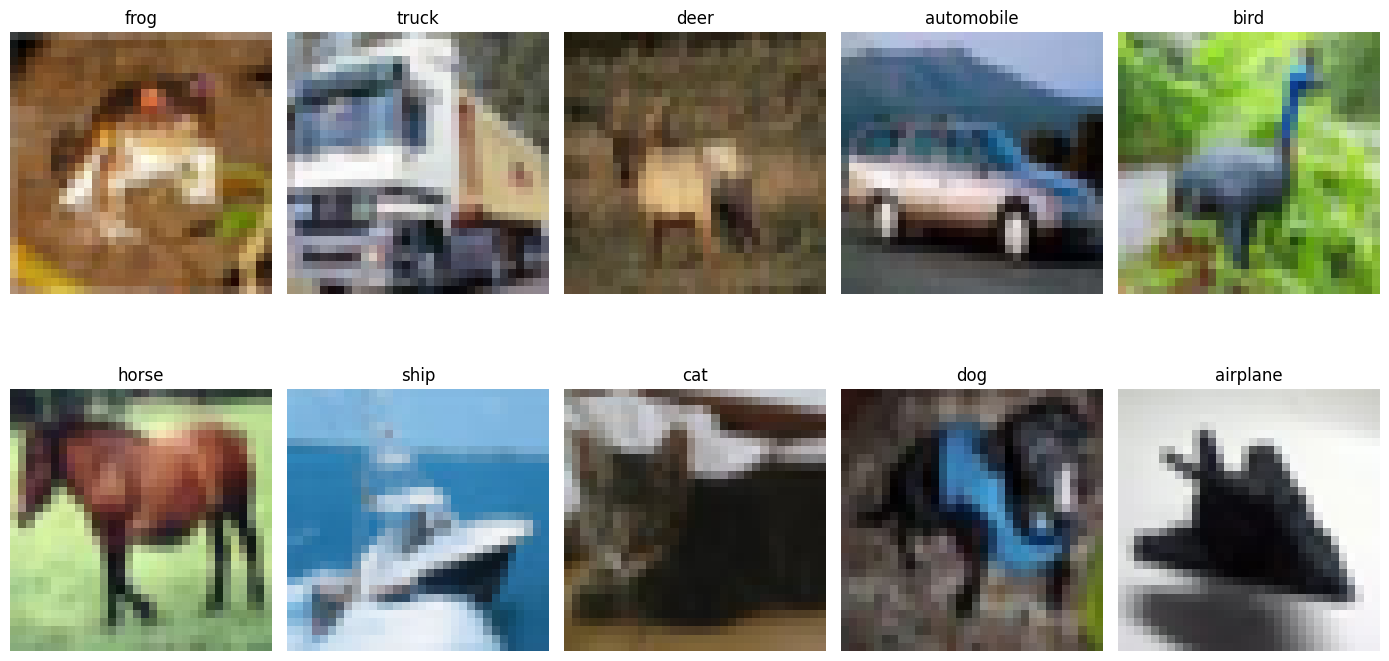

In [4]:

# ✅ Find One Image Per Class
class_images = {}
for img, label in full_dataset:
    if label not in class_images:
        class_images[label] = img
    if len(class_images) == 10:  # Stop when all classes are found
        break

# ✅ Plot Images
fig, axes = plt.subplots(2, 5, figsize=(14, 8))
axes = axes.flatten()

for i, (label, img) in enumerate(class_images.items()):
    img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].set_title(class_names[label])  # ✅ Use `class_names` instead of `.classes`
    axes[i].axis("off")

plt.tight_layout()
plt.show()


### Let's start here by examining the data

## Visualize a row of data

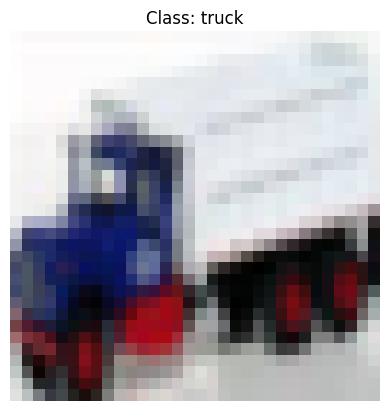

In [5]:

sample_idx = np.random.randint(0, len(full_dataset))
img, label = full_dataset[sample_idx]  # Extract image & label

# ✅ Convert Image for Display
img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

# ✅ Display Image with Label
plt.imshow(img)
plt.title(f"Class: {class_names[label]}")
plt.axis("off")
plt.show()


In [6]:
# Labels

# Each training and test example is assigned to one of the following labels:

# 0 airplane
# 1 automobile
# 2 bird
# 3 cat
# 4 deer
# 5 dog
# 6 frog
# 7 horse
# 8 ship
# 9 truck

## Example Dataloader

In [7]:

# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        """
        Initialize the dataset by passing a DataFrame.
        Args:
            dataframe (pd.DataFrame): DataFrame with pixel data and labels.
        """
        self.data = dataframe.iloc[:, :-1].values  # Features (all columns except the last)
        self.labels = dataframe.iloc[:, -1].values  # Labels (last column)

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a single sample from the dataset.
        Args:
            idx (int): Index of the sample to retrieve.
        Returns:
            (torch.Tensor, torch.Tensor): Tuple of features and label.
        """
        # Convert the features and label to tensors
        features = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return features, label



In [8]:
# Function to split the DataFrame and create DataLoaders
def create_train_test_dataloaders(dataframe, test_size=0.2, batch_size=64, shuffle=True):
    """
    Split the DataFrame into train and test sets and create DataLoaders.
    Args:
        dataframe (pd.DataFrame): DataFrame containing the data.
        test_size (float): Proportion of the data to be used as test data.
        batch_size (int): Number of samples per batch.
        shuffle (bool): Whether to shuffle the data.
    Returns:
        tuple: (train_loader, test_loader)
    """
    # Split the data into train and test sets
    train_df, test_df = train_test_split(dataframe, test_size=test_size, random_state=42)
    
    # Create train and test datasets
    train_dataset = CustomDataset(train_df)
    test_dataset = CustomDataset(test_df)
    
    # Create DataLoaders for train and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

## Manually Build dataloaders

In [9]:
# ✅ Load Full CIFAR-10 Dataset (Train + Test Combined)
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
full_train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
full_test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# ✅ Create DataLoaders
batch_size = 32
train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(full_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ✅ Get First Batch from Train & Test Loaders
train_batch = next(iter(train_loader))
test_batch = next(iter(test_loader))

# ✅ Print Shapes to Verify
train_batch_shape = (train_batch[0].shape, train_batch[1].shape)
test_batch_shape = (test_batch[0].shape, test_batch[1].shape)

train_batch_shape, test_batch_shape

Files already downloaded and verified
Files already downloaded and verified


((torch.Size([32, 3, 32, 32]), torch.Size([32])),
 (torch.Size([32, 3, 32, 32]), torch.Size([32])))

In [10]:
# Example: Check the first batch
for batch in train_loader:
    images, labels = batch
    print(f"Train Batch size: {images.shape}, Labels: {labels.shape}")
    break
# Example: Check the first batch
for batch in test_loader:
    images, labels = batch
    print(f"Test Batch size: {images.shape}, Labels: {labels.shape}")
    break

Train Batch size: torch.Size([32, 3, 32, 32]), Labels: torch.Size([32])
Test Batch size: torch.Size([32, 3, 32, 32]), Labels: torch.Size([32])


In [11]:
import torch
import torch.nn as nn

# ✅ Updated CustomCNN to Accept CIFAR-10 Batches (3-channel RGB images)
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10, kernel_size=3, stride=1, padding=1, dropout_prob=0.5):
        """
        Custom CNN adapted for CIFAR-10 (3-channel RGB input).
        
        Args:
            num_classes (int): Number of output classes.
            kernel_size (int): Convolutional kernel size.
            stride (int): Stride for convolution.
            padding (int): Padding for convolution.
            dropout_prob (float): Dropout probability.
        """
        super(CustomCNN, self).__init__()

        # Convolutional layers (Now for RGB input)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(16)  # Normalize after first Conv
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(32)  # Normalize after second Conv

        # Pooling and Dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling
        self.dropout = nn.Dropout(dropout_prob)

        # Activation functions
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

        # Fully connected layers (Adapted for 32x32 input)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)  # Adjusted for CIFAR-10 image size
        self.fc2 = nn.Linear(128, num_classes)  # Final classification layer

    def forward(self, x):
        """
        Forward pass adapted for CIFAR-10 batch input.
        """
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))  # Bottleneck layer
        x = self.dropout(x)  # Regularization
        out = self.fc2(x)  # Final classification layer
        
        return out  # Return logits

# ✅ Test with a Batch of CIFAR-10 Data
sample_batch = torch.randn(32, 3, 32, 32)  # Batch of 64 RGB images
model = CustomCNN()
output = model(sample_batch)

# ✅ Output Shape Should Be (64, 10) for 64 images and 10 classes
output.shape


torch.Size([32, 10])

In [12]:
# constructor: num_classes=10, kernel_size=3, stride=1, padding=1, dropout_prob=0.5
model = CustomCNN(num_classes=10, kernel_size=3, stride=1, padding=1, dropout_prob=0.5)

# Print the model architecture
print(model)

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### We Need This Now!

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model.to(device)
print(f"Using {device} device")


Using mps device


## Model Training

### Set Up TensorBoard Write

In [14]:
# Initialize TensorBoard Writer
writer = SummaryWriter(log_dir="runs/cnn_training")

# ✅ Create a Sample Input Tensor
sample_input = torch.randn(32, 3, 32, 32)
sample_input = torch.tensor(sample_input).to(device)

# ✅ Log Model Graph *Outside Any Forward Pass or Hooks*
try:
    writer.add_graph(model, sample_input)  # Ensure model is in eval mode when tracing
    print("🚀 Model successfully logged in TensorBoard!")
except Exception as e:
    print(f"❌ Error while logging model graph: {e}")

# ✅ Close Writer
writer.close()

/var/folders/83/s01xl68d2q3gdtkbr5ptq6nc0000gn/T/ipykernel_74152/293748301.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_input = torch.tensor(sample_input).to(device)


🚀 Model successfully logged in TensorBoard!


In [15]:

# ✅ Training Loop with TensorBoard Logging
# Training loop with timing
learning_rate = 0.0005
num_epochs = 50
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # ✅ Track training loss & accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        # ✅ Log every 100 batches
        if (i + 1) % 100 == 0:
            writer.add_scalar("Training Loss", loss.item(), epoch * len(train_loader) + i)

    # ✅ Compute epoch loss & accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # ✅ Validation Phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val

    # ✅ Log per-epoch metrics
    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_accuracy, epoch)
    writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)
    writer.add_scalar("Learning Rate", optimizer.param_groups[0]["lr"], epoch)

    # ✅ Log histograms of weights & biases
    for name, param in model.named_parameters():
        writer.add_histogram(name, param, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

end_time = time.time()
print(f"\n🚀 Training Completed in {end_time - start_time:.2f} seconds")

# ✅ Close TensorBoard writer
writer.close()


Epoch [1/50] | Train Loss: 1.5797, Train Acc: 0.4218 | Val Loss: 1.2611, Val Acc: 0.5617
Epoch [2/50] | Train Loss: 1.2861, Train Acc: 0.5380 | Val Loss: 1.1753, Val Acc: 0.5789
Epoch [3/50] | Train Loss: 1.1855, Train Acc: 0.5766 | Val Loss: 1.0167, Val Acc: 0.6380
Epoch [4/50] | Train Loss: 1.1297, Train Acc: 0.5996 | Val Loss: 0.9581, Val Acc: 0.6694
Epoch [5/50] | Train Loss: 1.0857, Train Acc: 0.6167 | Val Loss: 0.9604, Val Acc: 0.6693
Epoch [6/50] | Train Loss: 1.0546, Train Acc: 0.6280 | Val Loss: 0.9514, Val Acc: 0.6611
Epoch [7/50] | Train Loss: 1.0213, Train Acc: 0.6379 | Val Loss: 0.9140, Val Acc: 0.6809
Epoch [8/50] | Train Loss: 0.9963, Train Acc: 0.6490 | Val Loss: 0.9197, Val Acc: 0.6781
Epoch [9/50] | Train Loss: 0.9740, Train Acc: 0.6563 | Val Loss: 0.8854, Val Acc: 0.6928
Epoch [10/50] | Train Loss: 0.9517, Train Acc: 0.6612 | Val Loss: 1.0136, Val Acc: 0.6471
Epoch [11/50] | Train Loss: 0.9345, Train Acc: 0.6671 | Val Loss: 0.9391, Val Acc: 0.6740
Epoch [12/50] | Tra

## Saving and loading a model

In [16]:
torch.save(model.state_dict(), "cifar10_cnn.pth")
print("Model saved as 'cifar10_cnn.pth'")

Model saved as 'cifar10_cnn.pth'


In [17]:
# Load the saved model for inference
model = CustomCNN(num_classes=10, kernel_size=3, stride=1, padding=1, dropout_prob=0.0) # Reinitialize the model structure
model.load_state_dict(torch.load("cifar10_cnn.pth"))
model.eval()  # Set the model to evaluation mode
print("Model loaded and ready for inference.")


Model loaded and ready for inference.


In [18]:
# Cell 6: Inference loop
# Running inference
model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for efficiency
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 71.36%


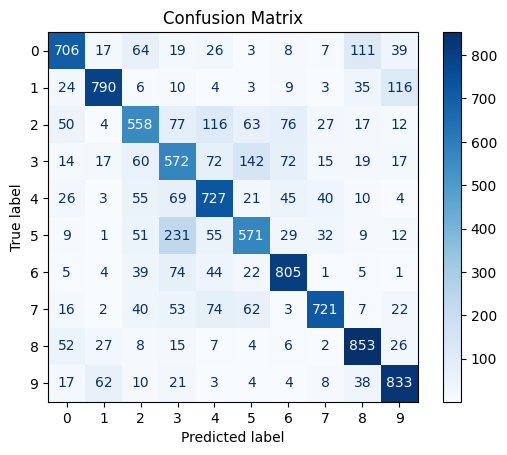

In [19]:

# Generate predictions for the entire dataset
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

# Compute and plot the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### Inspect a row of data

In [20]:
# ✅ Updated CIFAR-10 Inference Function Using `test_dataset` or `test_dataloader`
def run_inference_on_sample(sample_idx, model, dataset, device="cpu"):
    """
    Runs inference on a single sample from the CIFAR-10 dataset.

    Args:
        sample_idx (int): Index of the sample in the dataset.
        model (torch.nn.Module): Trained CNN model.
        dataset (Dataset): CIFAR-10 dataset (train or test).
        device (str): "cpu" or "cuda" for inference.

    Returns:
        int: Predicted label.
    """
    # ✅ Extract Image & Label from Dataset
    image, label = full_dataset[sample_idx]  # Get (image, label) from dataset

    # ✅ Ensure image is on the correct device
    image = image.unsqueeze(0).to(device)  # Add batch dimension (1, 3, 32, 32)

    # ✅ Perform inference
    model.to(device)
    model.eval()
    with torch.no_grad():
        logits = model(image)  # Raw logits
        probabilities = torch.softmax(logits, dim=1)  # Convert logits to probabilities

    # ✅ Get predicted label
    predicted_label = torch.argmax(probabilities, dim=1).item()

    # ✅ Print details
    print("Logits:", logits.cpu().numpy())
    print("Softmax Probabilities:", probabilities.cpu().numpy())
    print("Correct Label:", label)
    print("Predicted Label:", predicted_label)

    return predicted_label

# ✅ Example: Run inference on a sample from test_dataset
sample_index = 10  # Choose a sample index
predicted_label = run_inference_on_sample(sample_index, model, test_dataset)


Logits: [[-15.177873   -23.783434    -0.4735489    0.2114904    5.9154973
   -2.1785243   -0.23032309  -9.095208   -12.458434   -16.384947  ]]
Softmax Probabilities: [[6.8554740e-10 1.2551341e-13 1.6674176e-03 3.3079050e-03 9.9259454e-01
  3.0309786e-04 2.1265515e-03 3.0040360e-07 1.0400989e-08 2.0502756e-10]]
Correct Label: 4
Predicted Label: 4


In [21]:
### Display examples of correct and incorrect predictions

In [22]:
# # ✅ Define Transformations
# transform = transforms.Compose([transforms.ToTensor()])

# # ✅ Reload the Test Dataset
# test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# # ✅ Create DataLoader
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# print(f"✅ Reloaded test_dataset with {len(test_dataset)} samples.")

In [23]:
def display_examples(data_df, model, correct=True, num_examples=3):
    count = 0
    plt.figure(figsize=(10, 5))

    for idx, row in full_dataset.iterrows():
        if count >= num_examples:
            break

        # Extract image and label
        image_row = row[:-1]
        true_label = row[-1]

        # Run inference
        predicted_label = run_inference_on_row(image_row, true_label, model)

        # Check if prediction is correct
        if (predicted_label == true_label and correct) or (predicted_label != true_label and not correct):
            # Plot the image
            plt.subplot(1, num_examples, count + 1)
            image = image_row.values.reshape(28, 28)  # Reshape to 28x28
            plt.imshow(image, cmap="gray")
            plt.title(f"True: {true_label}, Pred: {predicted_label}")
            plt.axis("off")
            count += 1


In [24]:
# ✅ Store Correct & Incorrect Predictions
correct_samples = []
incorrect_samples = []

# ✅ Loop Over a Few Samples for Inference
num_samples = 100  # Check first 50 test samples
for i in range(num_samples):
    img, true_label = test_dataset[i]  # Get (image, label)
    predicted_label = run_inference_on_sample(i, model, test_dataset)
    
    if predicted_label == true_label:
        correct_samples.append((img, true_label, predicted_label))
    else:
        incorrect_samples.append((img, true_label, predicted_label))
    
    # ✅ Debugging Output
    print(f"Sample {i}: True Label: {true_label}, Predicted: {predicted_label}")

    # ✅ Stop if enough samples are collected
    if len(correct_samples) >= 6 and len(incorrect_samples) >= 6:
        break

# ✅ Check if we collected any samples
print(f"\n✅ Correct Samples Collected: {len(correct_samples)}")
print(f"❌ Incorrect Samples Collected: {len(incorrect_samples)}")


Logits: [[-16.173996   -18.265629    -0.63186806   1.884768    -1.0993661
   -1.1719719    3.3601162   -7.7903633  -12.870361   -12.90813   ]]
Softmax Probabilities: [[2.5870734e-09 3.1946562e-10 1.4543516e-02 1.8014848e-01 9.1125034e-03
  8.4743286e-03 7.8770971e-01 1.1318127e-05 7.0397796e-08 6.7788626e-08]]
Correct Label: 6
Predicted Label: 6
Sample 0: True Label: 3, Predicted: 6
Logits: [[ -5.7150507  -2.3295836  -7.284418  -13.066288  -16.747036  -11.187369
  -26.883795   -8.68078    -7.0318723   8.074454 ]]
Softmax Probabilities: [[1.0263141e-06 3.0308896e-05 2.1365479e-07 6.5868538e-10 1.6601583e-11
  4.3120369e-09 6.5737311e-16 5.2878679e-08 2.7503737e-07 9.9996817e-01]]
Correct Label: 9
Predicted Label: 9
Sample 1: True Label: 8, Predicted: 9
Logits: [[-1.1207585   0.14877096 -6.6042314  -5.96702    -8.580562   -7.999239
  -8.763325   -8.457894   -1.8293674   3.855075  ]]
Softmax Probabilities: [[6.6695213e-03 2.3738012e-02 2.7711018e-05 5.2407089e-05 3.8401072e-06
  6.8676568

/var/folders/83/s01xl68d2q3gdtkbr5ptq6nc0000gn/T/ipykernel_74152/2026799769.py:17: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/steveschmidt/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


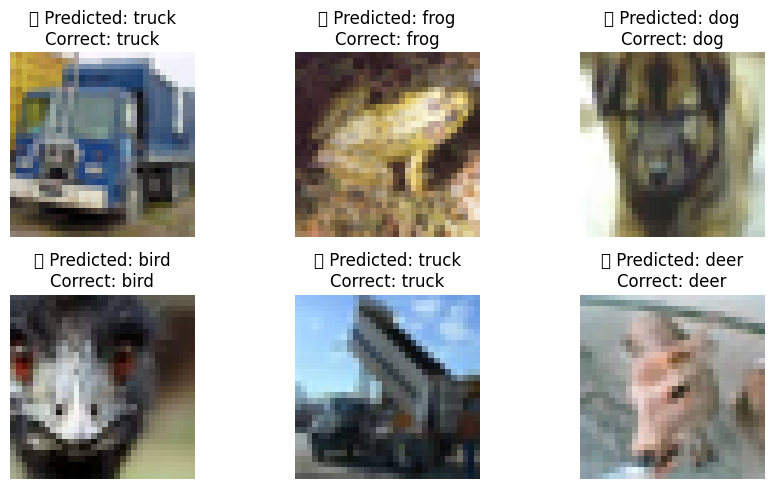

In [25]:
# ✅ Define CIFAR-10 Class Names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# ✅ Plot Correctly Classified Images
fig, axes = plt.subplots(2, 3, figsize=(9, 5))
axes = axes.flatten()

for i, (img, true_label, predicted_label) in enumerate(correct_samples[:6]):
    img = img.permute(1, 2, 0).numpy()  # Convert to H x W x C format
    axes[i].imshow(img)
    axes[i].set_title(f"✅ Predicted: {class_names[predicted_label]}\nCorrect: {class_names[true_label]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


/var/folders/83/s01xl68d2q3gdtkbr5ptq6nc0000gn/T/ipykernel_74152/3678434867.py:15: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/steveschmidt/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


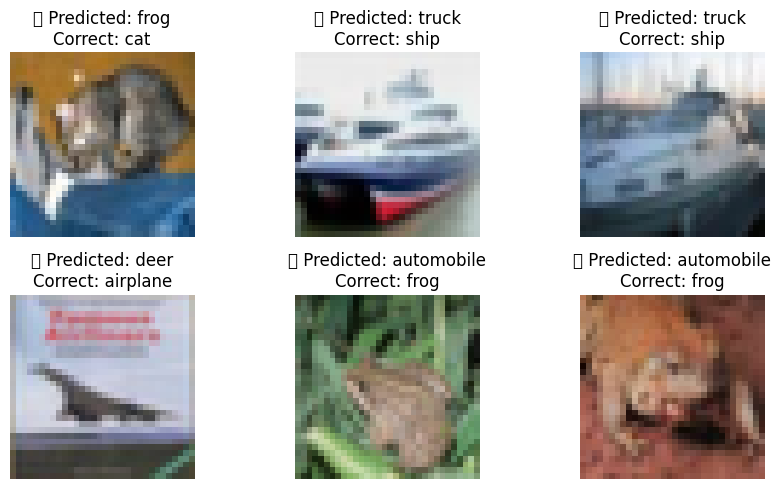

In [26]:
# ✅ Check if we have incorrect samples
if len(incorrect_samples) == 0:
    print("⚠️ No incorrect predictions found! Try increasing `num_samples`.")
else:
    # ✅ Plot Incorrectly Classified Images
    fig, axes = plt.subplots(2, 3, figsize=(9, 5))
    axes = axes.flatten()

    for i, (img, true_label, predicted_label) in enumerate(incorrect_samples[:6]):
        img = img.permute(1, 2, 0).numpy()  # Convert to H x W x C format
        axes[i].imshow(img)
        axes[i].set_title(f"❌ Predicted: {class_names[predicted_label]}\nCorrect: {class_names[true_label]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


In [27]:
# %load_ext tensorboard

# %tensorboard --logdir=runs/cnn_training